# Convolutional Variational Autoencoder for Handwritten Digit


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it.

In [66]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

In [68]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows, img_cols, 1)
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 28, 28, 1)
60000 train samples, 10000 test samples


## The model

In [70]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2
strides = 2
padding = 'same'

### Fill in the empty block to complete building an encoder model

In [72]:
# network parameters
input_shape = (img_rows, img_cols, 1)
kernel_size = 3
filters = 32
latent_dim = 2

# build encoder model
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs

fill in the code in the following block to reflect the encoder in the VAE, you can refer to the decoder model below to build a mirrored version of the encoder

In [74]:
# First Convolutional Layer
x = layers.Conv2D(filters=32, 
                  kernel_size=3, 
                  activation='relu', 
                  padding='same')(inputs)

# Second Convolutional Layer (with Stride 2)
x = layers.Conv2D(filters=32, 
                  kernel_size=3, 
                  activation='relu', 
                  strides=2, 
                  padding='same')(x)

# Save shape before flattening (to use in decoder)
shape = list(K.int_shape(x))
shape[0] = -1

# Flatten Layer
x = layers.Flatten()(x)

# Fully Connected Dense Layer
x = layers.Dense(16, activation='relu')(x)

# Latent Space (z_mean & z_log_var)
mu = layers.Dense(latent_dim, name='mu')(x)
log_sigma = layers.Dense(latent_dim, name='log_sigma')(x)

# Define Sampling Function
def sampling(args):
    """Reparameterization trick: sample z ~ N(mean, exp(log_var))"""
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return mean + K.exp(0.5 * log_var) * epsilon

# Sampled Latent Vector (z)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_sigma])

In [76]:
# instantiate encoder model
encoder = Model(inputs, [mu,log_sigma,z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 6272)      │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │    100,368 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_sigma (Dense)   │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ mu[0][0],         │
│                     │                   │            │ log_sigma[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,004 (429.70 KB)

 Trainable params: 110,004 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Build a decoder model

In [78]:
# use reparameterization trick to push the sampling out as input instead of sampling from Q(z|X)

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps

    Arguments:
        args:       mean and log of variance of Q(z|X)

    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))

    return mean + K.exp(0.5 * log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_sigma])

In [84]:
# instantiate encoder model
encoder = Model(inputs, [mu, log_sigma, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 6272)      │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │    100,368 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_sigma (Dense)   │ (None, 2)         │         34 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ mu[0][0],         │
│                     │                   │            │ log_sigma[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,004 (429.70 KB)

 Trainable params: 110,004 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [86]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(16, activation='relu')(latent_inputs)
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(x)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

x = layers.Conv2DTranspose(filters=filters,
                           kernel_size=kernel_size,
                           activation='relu',
                           strides=2,
                           padding='same')(x)

outputs = layers.Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6272)           │       106,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,209 (453.94 KB)

 Trainable params: 116,209 (453.94 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [88]:
# Create a Custom Layer to Compute and Add the Loss
class VAELossLayer(layers.Layer):
    def __init__(self, img_rows, img_cols, **kwargs):
        self.img_rows = img_rows
        self.img_cols = img_cols
        super(VAELossLayer, self).__init__(**kwargs)
    def call(self, inputs):
        encoder_inputs, decoder_outputs, mu, log_sigma = inputs
        reconstruction_loss = binary_crossentropy(K.flatten(encoder_inputs),
                                                  K.flatten(decoder_outputs))
        reconstruction_loss *= self.img_rows * self.img_cols
        kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(K.mean(total_loss))
        return decoder_outputs

In [90]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # Connect decoder to encoder output

# Wrap the Loss Computation in the Custom Layer
# The loss will be computed and added to the model when this layer is called.
loss_layer = VAELossLayer(img_rows, img_cols, name='vae_loss')([inputs, outputs, mu, log_sigma])

# Build the VAE Model with the loss layer included
vae = Model(inputs, [outputs, loss_layer], name='vae_model')  # Include loss layer in outputs

vae.compile(optimizer=keras.optimizers.Adam(0.001))

In [92]:
BATCH = 100
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - loss: 255.5267 - val_loss: 194.3827
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 193.5525 - val_loss: 188.3017
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 183.1256 - val_loss: 172.7874
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - loss: 171.2118 - val_loss: 167.2439
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 166.4940 - val_loss: 164.6357
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 163.9613 - val_loss: 163.9853
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 162.6548 - val_loss: 161.8188
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 161.6124 - val_loss: 160.9926
Epoch 9/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 160.2876 - val_loss: 160.5990
Epoch 10/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 160.1873 - val_loss: 159.8823
Epoch 11/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 159.4175 - val_l

In [94]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


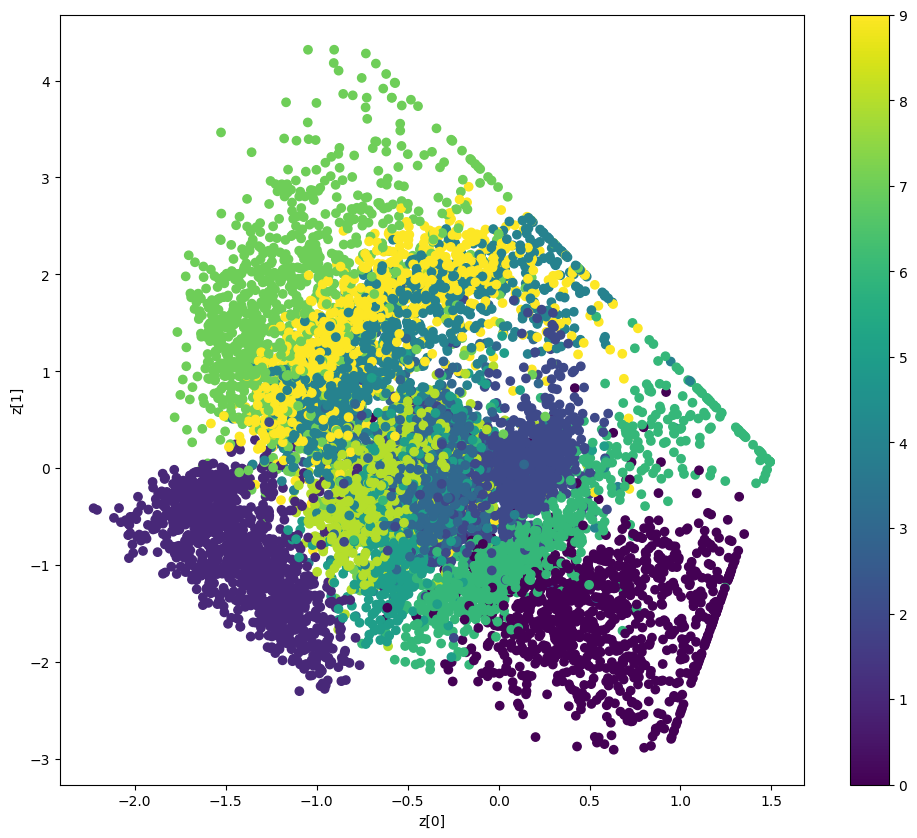

In [96]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_cnn")